# DNN Model

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# data loading from .npz generated from tcr_data_process.ipynb
# loading train data
npz = np.load('data_train.npz')
train_inputs = npz['input'].astype(np.float64)
train_targets = npz['targets'].astype(np.float64)
# loading validation data
npz = np.load('data_validation.npz')
validation_inputs, validation_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

npz = np.load('data_test.npz')
test_inputs, test_targets = npz['input'].astype(np.float64), npz['targets'].astype(np.float64)

# ANN Model

Outline, Optimizer, Loss function, Early stopping and Training rate

In [4]:
# NN model prep
input_size = 3
output_size = 1
hidden_layer_1_size = 15
hidden_layer_2_size = 15
hidden_layer_3_size = 10

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size),
    tf.keras.layers.Dense(hidden_layer_1_size, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(hidden_layer_2_size, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(hidden_layer_3_size, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(output_size, activation='linear')
])


2023-01-13 00:29:36.981621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-13 00:29:36.981651: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-13 00:29:36.981676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nirmal): /proc/driver/nvidia/version does not exist
2023-01-13 00:29:36.982143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# model prep, optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [6]:
# Training
BATCH_SIZE = 1
MAX_EPOCHS = 500
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [7]:
# fit the model
history = model.fit(
    train_inputs, train_targets, batch_size=BATCH_SIZE,epochs=MAX_EPOCHS, callbacks=[early_stopping], validation_data=(validation_inputs, validation_targets), verbose=2
          )

Epoch 1/500
640/640 - 2s - loss: 2.5551 - root_mean_squared_error: 1.5985 - val_loss: 2.5776 - val_root_mean_squared_error: 1.6055 - 2s/epoch - 3ms/step
Epoch 2/500
640/640 - 1s - loss: 2.2237 - root_mean_squared_error: 1.4912 - val_loss: 2.2552 - val_root_mean_squared_error: 1.5017 - 721ms/epoch - 1ms/step
Epoch 3/500
640/640 - 1s - loss: 1.9390 - root_mean_squared_error: 1.3925 - val_loss: 1.9752 - val_root_mean_squared_error: 1.4054 - 716ms/epoch - 1ms/step
Epoch 4/500
640/640 - 1s - loss: 1.6907 - root_mean_squared_error: 1.3003 - val_loss: 1.7294 - val_root_mean_squared_error: 1.3151 - 728ms/epoch - 1ms/step
Epoch 5/500
640/640 - 1s - loss: 1.4725 - root_mean_squared_error: 1.2134 - val_loss: 1.5098 - val_root_mean_squared_error: 1.2287 - 789ms/epoch - 1ms/step
Epoch 6/500
640/640 - 1s - loss: 1.2832 - root_mean_squared_error: 1.1328 - val_loss: 1.3202 - val_root_mean_squared_error: 1.1490 - 818ms/epoch - 1ms/step
Epoch 7/500
640/640 - 1s - loss: 1.1186 - root_mean_squared_error: 

In [8]:
# ANN model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 3)                    12        
                                                                 
 dense_1 (Dense)             (1, 15)                   60        
                                                                 
 dense_2 (Dense)             (1, 15)                   240       
                                                                 
 dense_3 (Dense)             (1, 10)                   160       
                                                                 
 dense_4 (Dense)             (1, 1)                    11        
                                                                 
Total params: 483
Trainable params: 483
Non-trainable params: 0
_________________________________________________________________


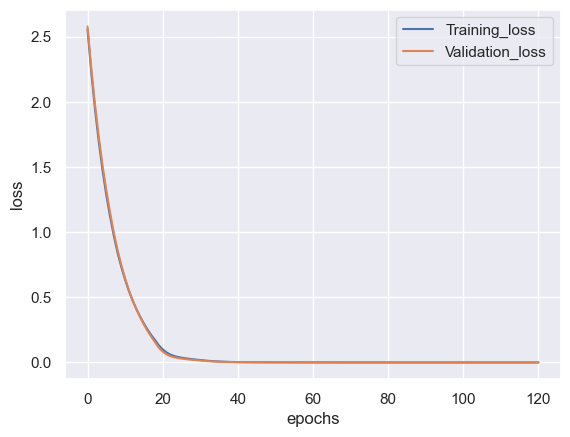

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.legend()
plt.show()
plt.savefig('loss_ann1.png')

# Model check on Test data

In [10]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

3/3 [==============================] - 0s 2ms/step - loss: 2.8737e-06 - root_mean_squared_error: 0.0017


In [11]:
print('\nTest loss: {0:.4f}. Test accuracy: {1:.4f} rmse'.format(test_loss, test_accuracy))


Test loss: 0.0000. Test accuracy: 0.0017 rmse


In [12]:
prediction = model.predict(test_inputs)
data_inputs = pd.DataFrame(test_inputs)
prediction = pd.DataFrame(np.round(prediction,3))
test_targets = pd.DataFrame(test_targets)
pred_accu = np.round((prediction/test_targets)*100,2)

result = pd.concat([test_targets, prediction, pred_accu], axis = 1, ignore_index=True)
result.columns = ['Target-St(%)', 'Prediction-St(%)','Pred-Accu-St(%)']
result

3/3 [==============================] - 0s 3ms/step


,Target-St(%),Prediction-St(%),Pred-Accu-St(%)
0,0.968,0.968,100.00
1,0.975,0.976,100.10
2,0.968,0.968,100.00
3,0.977,0.976,99.90
4,0.985,0.986,100.10
...,...,...,...
75,0.930,0.933,100.32
76,0.961,0.963,100.21
77,0.977,0.975,99.80
78,0.971,0.968,99.69


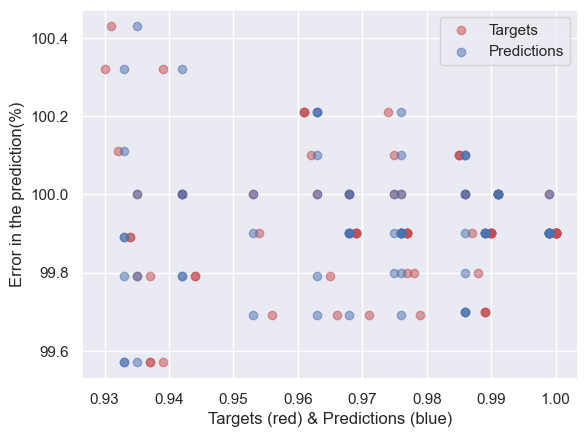

In [13]:
import matplotlib.pyplot as plt
plt.scatter(result['Target-St(%)'], result['Pred-Accu-St(%)'], alpha=0.5, color='r', label='Targets')
plt.scatter(result['Prediction-St(%)'], result['Pred-Accu-St(%)'],alpha=0.5, color='b', label='Predictions')
plt.ylabel('Error in the prediction(%)')
plt.xlabel('Targets (red) & Predictions (blue)')
plt.legend()
plt.savefig('pred1.png')


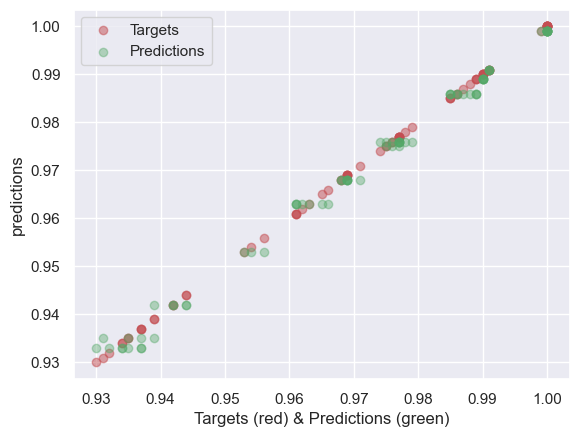

In [14]:
plt.scatter(result['Target-St(%)'], result['Target-St(%)'], alpha=0.5, color='r', label='Targets')
plt.scatter(result['Target-St(%)'], result['Prediction-St(%)'], alpha=0.4, color='g', label='Predictions')

plt.ylabel('predictions')
plt.xlabel('Targets (red) & Predictions (green)')
plt.legend()
plt.savefig('pred2.png')

In [15]:
# estimation of R2 score
from sklearn.metrics import r2_score
r2_score_test = r2_score(test_targets, prediction)
np.round(r2_score_test,4)

0.9937

In [16]:
# estimation of adjusted R2 score
n = np.size(test_targets)
k = 3 # number of features
adj_r2_score = 1 - (((1-r2_score_test)*(n-1))/((n-k-1)))
np.round(adj_r2_score,4)

0.9935

In [17]:
mean_pred = pred_accu.mean()
std_pred = pred_accu.std()
uncertainty_model = std_pred
print("Uncertainty of the ANN model:", np.round(uncertainty_model[0],2), '[%]')
print("Average test prediction precision", np.round(100 - uncertainty_model[0],2), '[%]')

Uncertainty of the ANN model: 0.16 [%]
Average test prediction precision 99.84 [%]


# ANN Model Deployment

ANN model deployment for micro DSC error prediction

In [18]:
import keras
model.save('micro_dsc_dl.h5')

In [19]:
import keras
model.save('micro_dsc_dl.hdf5')